In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
from pandas_ml_common import Constant
from pandas_ml_utils import FeaturesAndLabels, Model, SkModel, MultiModel
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels

# allow export of cells
from pandas_ml_common.utils import register_wirte_and_run_magic
register_wirte_and_run_magic()

# make experiments reproducable
import torch as t
t.manual_seed(0)

# globals
SYMBOL = "T"
START_DATE = "1995-01-01"
MODEL_REPOSITORY = "/home/kic/models"
MODEL_TYPE = "BN-Var-ConvAE"

automatically imported pandas_ml_utils 0.1.6


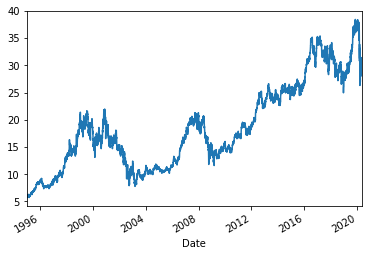

In [2]:
df = pd.fetch_yahoo(SYMBOL)[START_DATE:] if START_DATE is not None else pd.fetch_yahoo(SYMBOL)
df["Close"].plot()

In [3]:
from IPython.display import clear_output

def inverse_gaf(values):
    values = values[0] # use first channel
    return np.sqrt(((np.diag(values) + 1) / 2))
    
def plot_callback(y, y_hat, y_val, y_hat_val, epoch):
    y_hat = y_hat[0]
    y_hat_val = y_hat_val[0]
    clear_output(wait=True)
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))    
    ax[0, 0].set_title(f'epoch {epoch}')

    for i in range(5):
        _y = inverse_gaf(y[i])
        _y_hat = inverse_gaf(y_hat[i])

        _y_val = inverse_gaf(y_val[i])
        _y_hat_val = inverse_gaf(y_hat_val[i])
        
        ax[0, i].plot(_y, label="original")
        ax[0, i].plot(_y_hat, label="reconstructed")
        ax[1, i].plot(_y_val, label="original val")
        ax[1, i].plot(_y_hat_val, label="reconstructed val")
        
    ax[0, -1].legend()
    ax[1, -1].legend()
    plt.show()
            
f_n_l = FeaturesAndLabels(
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    targets = [lambda df: df["Close"] > df["Close"].shift(16)]
)

(f, _), l, t, w, gl = df._.extract(f_n_l)
label = l._.values

# plot and simulate a batch
#plot_callback(label[:10], label[:10], label[:10], label[:10], 0)

f.tail()

,Close_gaf
Date,
2020-05-07,"[[-0.9971303948576675, -0.9992823411973384, -0..."
2020-05-08,"[[-0.7130394857667586, -0.9104713113234343, -0..."
2020-05-11,"[[-0.9001090449954088, -0.8174222855594702, -0..."
2020-05-12,"[[-0.9971303948576675, -0.9655425610127306, -0..."
2020-05-13,"[[-1.0, -0.970891194026706, -0.922403536177445..."


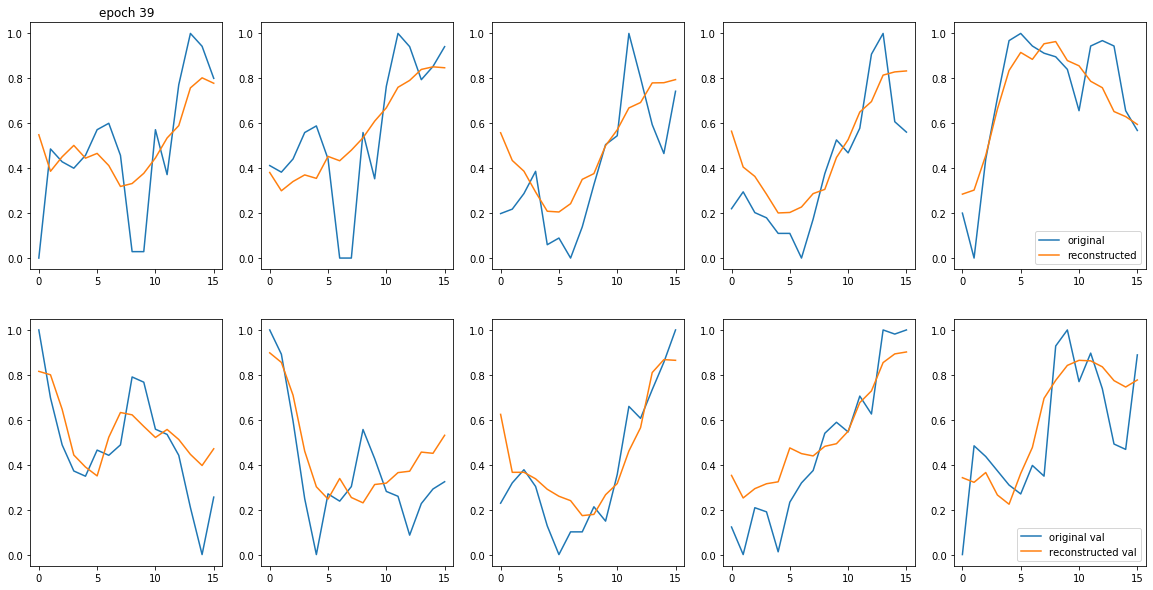

saved model to: /home/kic/models/T-BN-Var-ConvAE.model


In [4]:
%%write_and_run {MODEL_REPOSITORY}/{SYMBOL}-{MODEL_TYPE}.model.py

import torch as t
import torch.nn as nn
from torch.optim import Adam, Adagrad, RMSprop
from pandas_ml_utils import FeaturesAndLabels, PytorchModel, AutoEncoderModel
from pandas_ml_utils.pytorch import Reshape
from pandas_ml_quant.pytorch.custom_loss import SoftDTW
from pandas_ml_utils.pytorch.loss import MultiObjectiveLoss


def auto_encoder_provider():
    class AutoEncoder(nn.Module):

        def __init__(self, activation = nn.Tanh):
            super().__init__()
            self.activation = activation

            self._encoder = nn.Sequential(
                nn.Conv2d(1, 16, 3, padding=1),  # 16 - 3 + 2*1 / 1 + 1 => (?, 16, 16)
                activation(),
                nn.MaxPool2d(2, 2),              # (16 - 2) / 2 +1 => 8
                nn.Conv2d(16, 4, 3, padding=1),
                activation(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(4, 1, 3, padding=1),
                activation(),
                nn.MaxPool2d(2, 2),

                nn.Flatten(),
                nn.BatchNorm1d(4)
            )

            self._decoder = nn.Sequential(            
                Reshape(1, 2, 2),

                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ConvTranspose2d(1, 4, 3, padding=1),
                activation(),

                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ConvTranspose2d(4, 16, 3, padding=1),
                activation(),
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ConvTranspose2d(16, 1, 3, padding=1),
                nn.Tanh()
            )
            
            self.normal = t.distributions.Normal(0, 1)
            self.mu = nn.Linear(4, 4)
            self.sigma = nn.Linear(4, 4)

        def forward(self, x):
            if self.training:
                _x = nn.Dropout(0.1)(x) if self.training else x
                _x = self._encoder(_x)
                
                mu = self.mu(_x)
                sigma = self.sigma(_x)
                _x = self._decoder(self._reparam(mu, sigma))
                return _x, (mu, sigma)
            else:
                _x = self._encoder(x)
                _x = self.mu(_x)
                _x = self._decoder(_x)
                return _x
            
        def _reparam(self, mu, logvar):
            std = logvar.mul(0.5).exp_()
            eps = self.normal.sample(std.size())
            return eps.mul(std).add_(mu)

        def encoder(self, x):
            with t.no_grad():
                _x = t.from_numpy(x).float()
                _x = self._encoder(_x)
                _x = self.mu(_x)
                return _x.numpy()

        def decoder(self, x):
            with t.no_grad():
                return self._decoder(t.from_numpy(x).float()).numpy()

    return AutoEncoder()


model = AutoEncoderModel(
    PytorchModel(
        FeaturesAndLabels(
            [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
            [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
        ),
        auto_encoder_provider,
        lambda: MultiObjectiveLoss(
            (1.0, nn.MSELoss(reduction='none')), 
            (0.1, lambda _, mu_sigma: -0.5 * t.sum(1 + mu_sigma[1] - mu_sigma[0].pow(2) - mu_sigma[1].exp())), 
            max_weight=3,
            on_epoch=lambda c, e: c.update_weights((1, 1.11))),
        Adam,
    ),
    [f"condensed{i}" for i in range(4)],
    lambda m: m.module.encoder,
    lambda m: m.module.decoder,
)

ae_fit = df.model.fit(
    model, 
    epochs=40, 
    batch_size=32, 
    on_epoch=[plot_callback]
)

ae_fit.model.as_encoder().save(f"{MODEL_REPOSITORY}/{SYMBOL}-{MODEL_TYPE}.model")

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f26dd0b0550>)

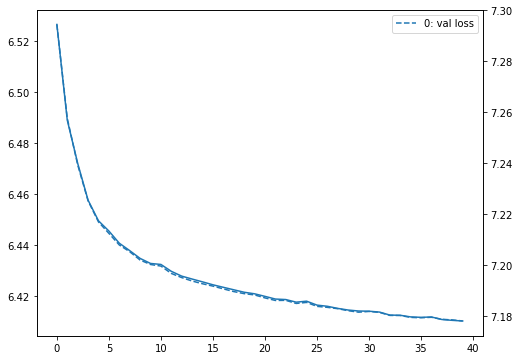

In [5]:
ae_fit.model.plot_loss(secondary_y=True)

In [6]:
encoder_model = ae_fit.model.as_encoder()
# encoder_model.save(f"{MODEL_REPOSITORY}/{SYMBOL}-BN-Var-ConvAE.model")
encoded_df = df.model.predict(encoder_model.as_encoder())
encoded_df.tail()

saved model to: /home/kic/models/T-BN-Var-ConvAE.model


prediction                                   \
           condensed0 condensed1 condensed2 condensed3   
Date                                                     
2020-05-07   2.153254  -1.463336  -1.033957  -0.232082   
2020-05-08   1.627823  -2.266509  -1.737307  -0.738247   
2020-05-11   1.931711  -0.579777  -0.536075  -0.736610   
2020-05-12   2.475720   0.884735   0.524889  -0.989051   
2020-05-13   4.215329   0.426614   0.491729  -1.447947   

                                                      feature  
                                                    Close_gaf  
Date                                                           
2020-05-07  [[-0.9971303948576675, -0.9992823411973384, -0...  
2020-05-08  [[-0.7130394857667586, -0.9104713113234343, -0...  
2020-05-11  [[-0.9001090449954088, -0.8174222855594702, -0...  
2020-05-12  [[-0.9971303948576675, -0.9655425610127306, -0...  
2020-05-13  [[-1.0, -0.970891194026706, -0.922403536177445...

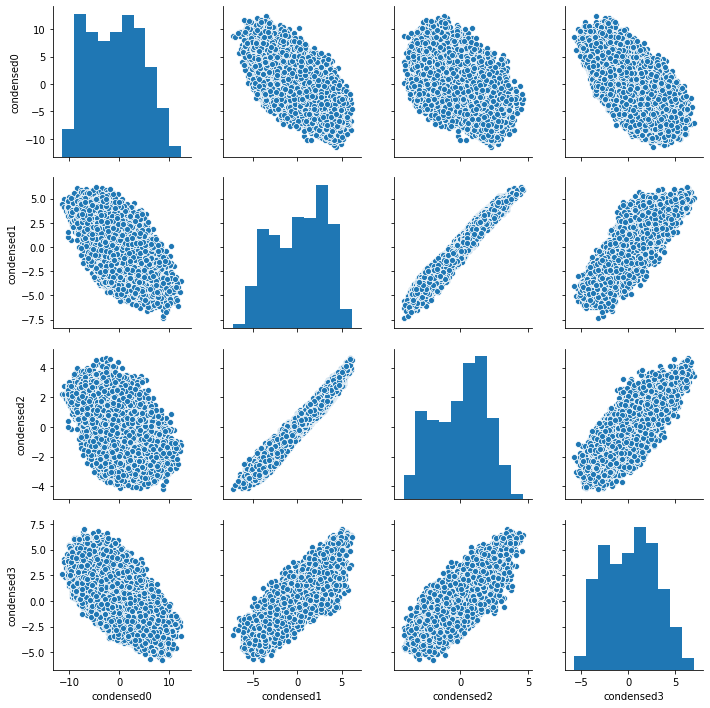

In [7]:
import seaborn as sns

sns.pairplot(encoded_df["prediction"])

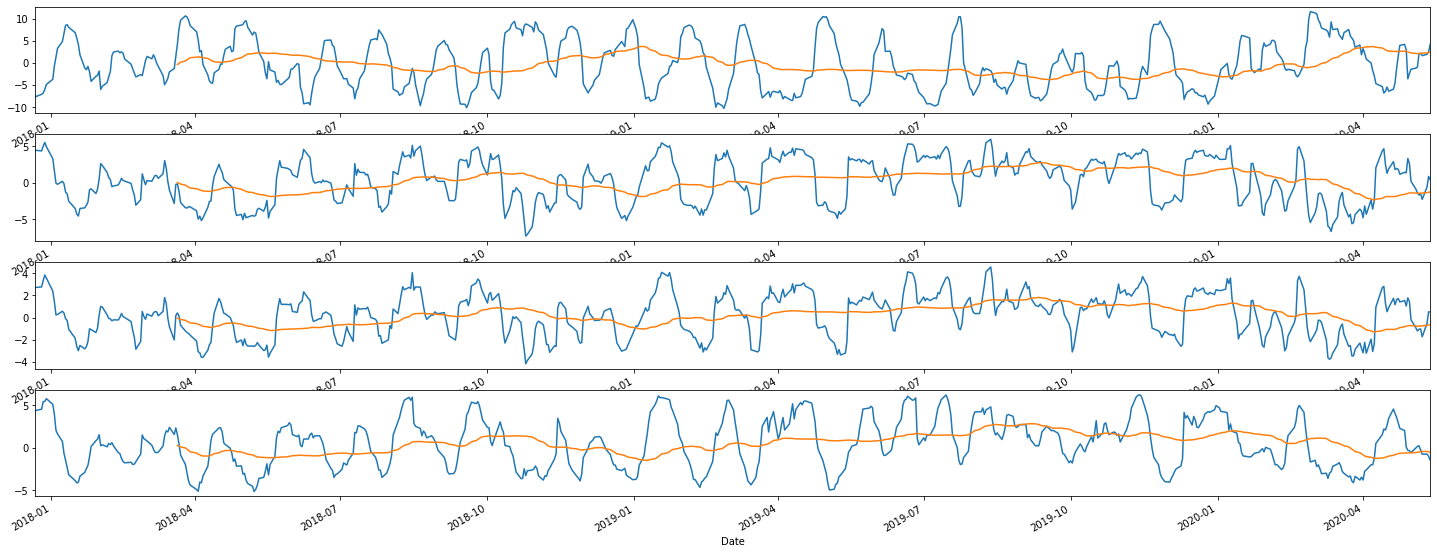

In [8]:
fig, ax = plt.subplots(4, 1, figsize=(25, 10))
pdf = encoded_df["prediction"][-600:]

for i, col in enumerate(pdf.columns):
    pdf[col].plot(ax=ax[i])
    pdf[col].ta.sma(60).plot(ax=ax[i])

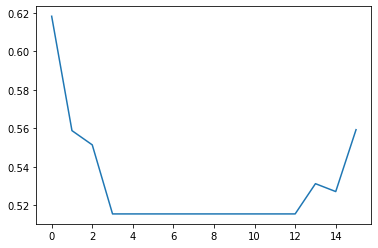

In [9]:
from pandas_ml_quant.analysis.encoders.gramian_angular_field import np_inverse_gaf

decoder_model = ae_fit.model.as_decoder(["condensed0", "condensed1", "condensed2", "condensed3"])

pgaf = pd.DataFrame({
    "condensed0": [0],
    "condensed1": [0],
    "condensed2": [0],
    "condensed3": [0],
}).model.predict(decoder_model)

plt.plot(np_inverse_gaf(np.array(pgaf.values[0, 0]))[0])

3.2463301694070696

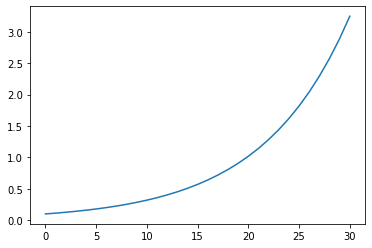

In [10]:
xx = 0.1
xl = [xx]
for i in range(30):
    xx *= 1.123
    xl.append(xx)

plt.plot(xl)
xx